# CITS4403 Project draft code

### Config


In [59]:
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import numpy as np
from time import sleep
from IPython.display import clear_output

## Parameters
ROOM_TEMPERATURE_CELSIUS = 25
HEAT_FIRE_STARTS_CELSIUS = 100

# Fire parameters
FIRE_EMISSION_CELSIUS = 150
FIRE_MAX_HEAT_CELSIUS = 1000
FIRE_EMISSION_KERNEL = np.array([[0, 0.6, 0], [0.6, 0.6, 0.6], [0, 0.6, 0]])

# Smoke parameters
SMOKE_EMISSION_KERNEL = np.array([[0, 0.2, 0], [0.2, 0, 0.2], [0, 0.2, 0]])
SMOKE_DISPERSION = 0.2

# Heat parameters
HEAT_DISPERSION = 0.04

# Display parameters
MAX_HEAT_DISPLAY_CELSIUS = 100
MIN_HEAT_DISPLAY_CELSIUS = 25
MAX_HEAT_TRANSPARENCY = 0.5

In [60]:
map = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
                [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
                [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
                [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [61]:
class Cell:
    def __init__(self, isBurnable):
        self.heatCelsius = ROOM_TEMPERATURE_CELSIUS

        self.smokeContent = 0
        self.isBurnable = isBurnable

        self.isOnFire = False

def hollow_dispersion_kernel(dispersion: float) -> np.ndarray:
    return np.array([[0, dispersion, 0], [dispersion, 0, dispersion], [0, dispersion, 0]])

def dispersion_kernel(dispersion: float) -> np.ndarray:
    return np.array([[0, dispersion, 0], [dispersion, 1 - 4 * dispersion, dispersion], [0, dispersion, 0]])


In [62]:
class BurnSimulation():
    def __init__(self, map):
        self.environment = np.array([[Cell(isBurnable) for isBurnable in row] for row in map])

        self.environment[4][5].heatCelsius = 150
        self.environment[4][5].isOnFire = True

    def step(self):
        # Calculate heat dispersion
        heatMap = np.array([[cell.heatCelsius for cell in row] for row in self.environment])
        heatDispersion = correlate2d(heatMap, dispersion_kernel(HEAT_DISPERSION), mode='same', boundary='fill', fillvalue=ROOM_TEMPERATURE_CELSIUS)

        # Calculate heat emissions from fire using convolution
        fires = np.array([[cell.isOnFire for cell in row] for row in self.environment])
        heatEmissions = correlate2d(fires, FIRE_EMISSION_KERNEL, mode='same', boundary='fill', fillvalue=0)

        # Add heat emissions to environment
        for i in range(len(self.environment)):
            for j in range(len(self.environment[i])):
                cell = self.environment[i][j]
                cell.heatCelsius = heatDispersion[i][j] + heatEmissions[i][j] * FIRE_EMISSION_CELSIUS
                cell.heatCelsius = min(cell.heatCelsius, FIRE_MAX_HEAT_CELSIUS)

                if cell.heatCelsius >= HEAT_FIRE_STARTS_CELSIUS and cell.isBurnable:
                    cell.isOnFire = True

        self.step_calculate_smoke(fires)

    def step_calculate_smoke(self, fires):
        # Calculate smoke dispersion:

        # 1. Calculate the neighbours of each cell, encoded as a bitset
        emptySpaceMap = np.array([[not cell.isBurnable for cell in row] for row in self.environment])
        neighboursMap = correlate2d(emptySpaceMap, np.array([[0, 2, 0], [4, 0, 1], [0, 8, 0]]), mode='same', boundary='fill', fillvalue=0)

        # 2. Calculate dispersion
        # Smoke modifications are a map of additions to the smoke content of each cell
        smokeModifications = np.zeros((len(self.environment), len(self.environment[0])))
        for y in range(len(self.environment)):
            for x in range(len(self.environment[y])):
                cell = self.environment[y][x]

                # If no smoke or neighbours are present, skip
                if (cell.smokeContent == 0 or neighboursMap[y][x] == 0):
                    continue

                # Get number of neighbours
                neighbours = neighboursMap[y][x]
                numNeighbours = bin(neighbours).count('1')

                # Remove smoke from cell
                newSmokeValue = cell.smokeContent * SMOKE_DISPERSION
                smokeModificationAdjustment = newSmokeValue - cell.smokeContent # Will be negative- smoke is dispersing from this tile
                smokeModifications[y][x] += smokeModificationAdjustment

                # Calculate how much smoke is going to each cell- will be positive
                smokeSpread = -smokeModificationAdjustment / numNeighbours

                # Add smoke to neighbours
                for neighbour in [[1, 0], [0, -1], [-1, 0], [0, 1]]:
                    # There should never be a risk of going out of bounds with the convolution done before
                    neighbourX = x + neighbour[0]
                    neighbourY = y + neighbour[1]

                    if neighbours & 1:
                        smokeModifications[neighbourY][neighbourX] += smokeSpread
                    neighbours >>= 1

        # Calculate smoke emission from fire
        newSmoke = correlate2d(fires, SMOKE_EMISSION_KERNEL, mode='same', boundary='fill', fillvalue=0)

        # Multiply smoke emissions by empty space map to prevent smoke from spreading to wall cells
        # If a cell is not burnable (0) then the smoke emission to that cell is 0
        # If a cell is burnable (1) then the smoke emission to that cell is the original smoke emission
        newSmoke *= emptySpaceMap

        # Add smoke emissions to environment, maxxing out at 100%
        for y in range(len(self.environment)):
            for x in range(len(self.environment[y])):
                cell = self.environment[y][x]
                cell.smokeContent = min(cell.smokeContent + smokeModifications[y][x] + newSmoke[y][x], 1)

    def draw(self):
        height, width = map.shape

        # Draw map
        plt.axis([0, height, 0, width])
        plt.xticks([])
        plt.yticks([])

        options={
            "cmap": 'Greens',
            "alpha": 0.7,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, height, 0, width]
        }

        plt.imshow(map, **options)

        # Draw heat on the environment
        heatMap = np.array([[min(cell.heatCelsius - MIN_HEAT_DISPLAY_CELSIUS, MAX_HEAT_DISPLAY_CELSIUS) / MAX_HEAT_TRANSPARENCY for cell in row] for row in self.environment])
        options={
            "cmap": 'Reds',
            "alpha": 0.5,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, height, 0, width]
        }

        plt.imshow(heatMap, **options)

        # Draw smoke on the environment
        smokeMap = np.array([[cell.smokeContent for cell in row] for row in self.environment])
        options={
            "cmap": 'gray',
            "alpha": 1,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, height, 0, width]
        }

        smokeMapImg = np.ones((height, width, 4)) * np.array([0, 0, 0, 1])
        smokeMapImg[:, :, 3] = smokeMap

        plt.imshow(smokeMapImg, **options)

        # Draw fire
        fireXs = []
        fireYs = []
        for y in range(height):
            for x in range(width):
                cell = self.environment[y][x]
                if cell.isOnFire:
                    fireXs.append(x + 0.5)
                    fireYs.append(height - y - 0.5)
        plt.plot(fireXs, fireYs, '.', color='red')
        plt.show()

    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step

        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

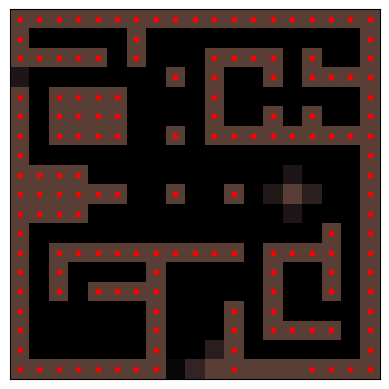

In [67]:
sim = BurnSimulation(map)

sim.animate(50, 0.1)